<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2* Jonatan Rivera

In [57]:
""" Import Statements """
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [220]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [274]:
from bs4 import BeautifulSoup
import requests

#display all text 
pd.set_option('display.max_colwidth', 100)
#convert joblisting csv into data frame 
df = pd.read_csv("data/job_listings.csv")
df.head(2)


,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>\nConceptual understanding in Machine Learning mod...",Data scientist
1,1,"b'<div>Job Description<br/>\n<br/>\n<p>As a Data Scientist 1, you will help us build machine lea...",Data Scientist I


In [230]:
#create function to extract descritption from html 
def text_extractor(x):
    """convert html to text """
    soup = BeautifulSoup(x, 'html.parser')
    x = soup.get_text()
    return x

In [231]:
# apply text extractor function
df['description'] = df['description'].apply(text_extractor)

In [232]:
df.head() , df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   426 non-null    int64 
 1   description  426 non-null    object
 2   title        426 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.1+ KB


(   Unnamed: 0  \
 0  0            
 1  1            
 2  2            
 3  3            
 4  4            
 
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [235]:
#further clean data frame
df.replace({'\\xe2\\x80\\x99':"","\\xe2\\x80\\x93":"","\\xe2\\x80\\x99":"","xe2x80x93":""},inplace=True)
df.replace({r'\\n':'', r"[^a-zA-Z 0-9]":""}, regex=True, inplace = True)

In [236]:
df.head()

,Unnamed: 0,description,title
0,0,bJob RequirementsConceptual understanding in Machine Learning models like Naixc2xa8ve Bayes KMeans SVM Apriori Linear Logistic Regression Neural Random Forests Decision Trees KNN along with handson experience in at least 2 of themIntermediate to expert level coding skills in PythonR Ability to write functions clean and efficient data manipulation are mandatory for this roleExposure to packages like NumPy SciPy Pandas Matplotlib etc in Python or GGPlot2 dplyr tidyR in RAbility to communicate Model findings to both Technical and NonTechnical stake holdersHands on experience in SQLHive or similar programming languageMust show past work via GitHub Kaggle or any other published articleMasters degree in StatisticsMathematicsComputer Science or any other quant specific fieldApply Now,Data scientist
1,1,bJob DescriptionAs a Data Scientist 1 you will help us build machine learning models data pipelines and microservices to help our clients navigate their healthcare journey You will do so by empowering and improving the next generation of Accolade Applications and user experiencesA day in the lifexe2x80xa6Work with a small agile team to design and develop mobile applications in an iterative fashionWork with a tightknit group of development team members in SeattleContribute to best practices and help guide the future of our applicationsOperates effectively as a collaborative member of the development teamOperates effectively as an individual for quick turnaround of enhancements and fixesResponsible for meeting expectations and deliverables on time with high qualityDrive and implement new features within our mobile applicationsPerform thorough manual testing and writing test cases that cover all areasIdentify new development toolsapproaches that will increase code quality efficiency and best practicesDevelop and champion the the development processes coding style guidelines and architectural designs necessary to innovate and maintain great product qualityEffectively turns design documents and graphics into performant usable UIDemonstrates creative technical and analytical skillsDemonstrates ability to communicate effectively in both technical and business environmentsQualificationsWhat we are looking forxe2x80xa6Masterxe2x80x99s Degree in Computer Science Math or related fieldComputer Science fundamentals as illustrated through algorithm design problem solving and complexity analysisMust have 1 year realworld experience developing and deploying microservices or data pipelinesMust have a fundamental understanding of key machine learning concepts such as accuracy measures crossvalidation and open source machine learning librariesFluent in Python and SQLProficient with writing unitfunctional tests and familiar with automation frameworksExperience with cloud infrastructure such as AWS or Azure is a plusExperience with distributed data pipelines such as a Spark is a plusStrong written and oral communication skillsDesire and willingness to work in an Agile collaborative innovative flexible and teamoriented environmentHandson detailoriented methodical inquisitiveA motivated selfstarter with a solid level of experience that quickly grasps complex challengesA skillful communicator with experience working with technical management teams A service oriented person who thinks Customer FirstFast fail entrepreneurial spiritThrives in a fastpaced environment where continuous improvement is the norm and the bar for quality is extremely highExcited by the challenges of working in a product team undergoing rapid international growthAdditional InformationWhat is important to usCreating an enduring company that is hyperfocused on our culture and making a meaningful impact in the lives of our employees members and customers The secret to our success isWe find joy and purpose in serving othersMaking a difference in our membersxe2x80x99 and customersxe2x80x99 lives is what we do Even when itxe2x80x99s hard we do the right thing 

## 2) Use Spacy to tokenize the listings 

In [237]:
#load nlp model in spacy
nlp = spacy.load("en_core_web_lg")

#create function to eventually use to tokenize description column
def get_lemmas(text):
    """ gives you the lemmas for a given text"""
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON') and (token.is_space == False):
            lemmas.append(token.lemma_)
    
    return lemmas
tokenized_listings = df['description'].apply(get_lemmas)

In [238]:
#see fist two listings
tokenized_listings[:2]

0    [bJob, RequirementsConceptual, understanding, Machine, Learning, model, like, naixc2xa8ve, Bayes, KMeans, SVM, Apriori, Linear, Logistic, regression, Neural, Random, Forests, Decision, Trees, KNN, handson, experience, 2, themintermediate, expert, level, coding, skill, PythonR, ability, write, function, clean, efficient, datum, manipulation, mandatory, roleexposure, package, like, NumPy, SciPy, Pandas, Matplotlib, etc, Python, GGPlot2, dplyr, tidyR, RAbility, communicate, Model, finding, Technical, NonTechnical, stake, holdershand, experience, sqlhive, similar, programming, languageMust, past, work, GitHub, Kaggle, publish, articlemaster, degree, statisticsmathematicscomputer, science, quant, specific, fieldapply]                                                                                                                                                                                                                                                                                 

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [240]:
#import count vectorizer, will be need to get word counts
from sklearn.feature_extraction.text import CountVectorizer

#list of text documents
job_list = df['description']

# create the transformer
# use the apply get_lemmas as my tokenizer
vect = CountVectorizer(stop_words = 'english', max_df =.90,min_df =2, tokenizer=get_lemmas)

# build vocab
vect.fit(job_list)

# transform text
dtm = vect.transform(job_list)



/Users/johnrivera/.virtualenvs/DS-Unit-4-Sprint-1-NLP-N2EbWurJ/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [241]:
print(dtm)

  (0, 31)	1
  (0, 107)	1
  (0, 609)	1
  (0, 702)	1
  (0, 1008)	1
  (0, 1054)	1
  (0, 1104)	1
  (0, 1533)	1
  (0, 1564)	1
  (0, 1799)	1
  (0, 1883)	1
  (0, 2135)	2
  (0, 2186)	1
  (0, 2330)	1
  (0, 2393)	1
  (0, 2451)	1
  (0, 2524)	1
  (0, 2527)	1
  (0, 2611)	1
  (0, 3099)	1
  (0, 3116)	1
  (0, 3121)	1
  (0, 3182)	1
  (0, 3208)	1
  (0, 3238)	2
  :	:
  (425, 5656)	1
  (425, 5690)	3
  (425, 5714)	2
  (425, 5786)	1
  (425, 5794)	1
  (425, 5830)	1
  (425, 5885)	2
  (425, 5909)	1
  (425, 5968)	1
  (425, 5980)	1
  (425, 5996)	1
  (425, 6003)	2
  (425, 6048)	1
  (425, 6055)	1
  (425, 6083)	1
  (425, 6095)	1
  (425, 6116)	1
  (425, 6133)	1
  (425, 6156)	1
  (425, 6214)	1
  (425, 6228)	7
  (425, 6233)	1
  (425, 6240)	1
  (425, 6273)	2
  (425, 6295)	2


In [242]:
type(dtm)

scipy.sparse.csr.csr_matrix

In [260]:
# Get Word Counts for each document
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())


AttributeError: 'DataFrame' object has no attribute 'todense'

,0,02,06366,1,10,100,1000,100000,100000125000the,1001schedulefulltimejob,...,youwe,youwhat,youxe2x80x99ll,youxe2x80x99re,youxe2x80x99ve,youyou,yrs,zero,zf,zfxe2x80x99s
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
423,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
424,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [244]:
#construct count function
from collections import Counter

def count(docs):
        """This function returns the a data frame providing information of the most popular word counts for a given
        corpus of documents"""
        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')
#Get counts of tokenized listings
wc = count(tokenized_listings)

In [245]:
wc

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
4,datum,405,2584,1.0,0.020811,0.020811,0.950704
48,work,362,1355,2.0,0.010913,0.031724,0.849765
319,team,358,1171,3.0,0.009431,0.041155,0.840376
50,experience,368,1109,4.0,0.008932,0.050087,0.863850
86,business,312,1073,5.0,0.008642,0.058729,0.732394
...,...,...,...,...,...,...,...
15940,DomesticRegionalVirtual,1,1,15953.0,0.000008,0.999968,0.002347
15939,Eligible,1,1,15954.0,0.000008,0.999976,0.002347
15956,JobNoCerner,1,1,15955.0,0.000008,0.999984,0.002347
15943,25000,1,1,15956.0,0.000008,0.999992,0.002347


(0.0, 100.0, 0.0, 100.0)

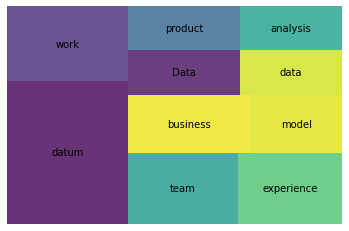

In [246]:
#Visualize the most common words
import squarify
import matplotlib.pyplot as plt
wc_top= wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top['pct_total'], label=wc_top['word'], alpha=.8 )
plt.axis('off')

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [247]:
#We want to convert a collection of raw documents to a matrix of TF-IDF features
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(ngram_range=(1,2),
                        max_df=.97,
                        min_df=.02,
                        tokenizer=get_lemmas)
data = df['description']
# And create a vocabulary and get word counts per document

# Similiar to fit_predict
dtm2 = tfidf.fit_transform(data)


# Print word counts

# Get feature names to use as dataframe column headers
dtm2 = pd.DataFrame(dtm2.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm2.head()

,1,1 year,10,100,12,12 month,2,2 year,2019,25,...,year relevant,year work,yearsxe2x80x99,yearsxe2x80x99 experience,york,york city,youxe2x80x99ll,youxe2x80x99ll work,youxe2x80x99re,youxe2x80x99ve
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.144098,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.135976,0.079861,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [263]:
##### Your Code Here #####
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm2)


NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [266]:
#Identify k nearest neighboors nearest to my query for the first document(observation)
#Nearest Neighboor model is based on dtm2  (document term matrix created above)
nn.kneighbors([dtm2.iloc[0].values])

(array([[0.        , 1.27364016, 1.27364016, 1.27727877, 1.28130477]]),
 array([[  0,  42, 138, 403, 366]]))

In [268]:
# Make query based on my descritpion of my ideal data science job
ideal_job = ["""My ideal job is one where I can apply software engineering,data wrangling, machine learning to solve problems dealing with setting up data infrastructures"""]
new = tfidf.transform(ideal_job)

In [269]:
new

<1x2532 sparse matrix of type '<class 'numpy.float64'>'
	with 18 stored elements in Compressed Sparse Row format>

In [270]:
nn.kneighbors(new.todense())

(array([[1.28476157, 1.30351228, 1.30739224, 1.30748933, 1.30952434]]),
 array([[276, 115, 307, 399, 130]]))

In [271]:
# Inspect Most relevant result
data[276]

'bFacebooks mission is to give people the power to build community and bring the world closer together Through our family of apps and services were building a different kind of company that connects billions of people around the world gives them ways to share what matters most to them and helps bring people closer together Whether were creating new products or helping a small business expand its reach people at Facebook are builders at heart Our global teams are constantly iterating solving problems and working together to empower people around the world to build community and connect in meaningful ways Together we can help people build stronger communities xe2x80x94 were just getting startedThe Infrastructure Strategy group is responsible for the strategic analysis to support and enable the continued growth critical to Facebookxe2x80x99s infrastructure organization The ideal candidate will be passionate about Facebook have strong analytical and modeling aptitude and has experience usi

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 